# Digits

Run the source code:

In [67]:
%run "code\digits.py"

## Example 7.1

The code below constructs the exact model and verifies it correctly classifies any random image selected from the possible inputs containing digits. The `random_image()` function selects an image from a dataset called `IM` which contains these images.

8


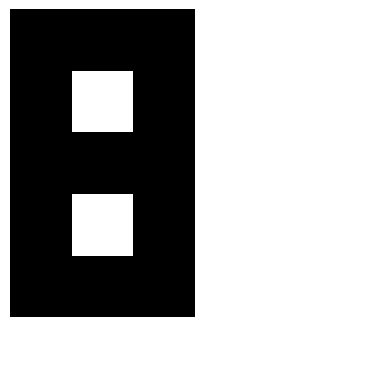

In [68]:
M = make_exact_model()
rand_img = random_image()
print(model_classify(M=M, img=rand_img))
show_digit(rand_img)

We can also test some example images that do not contain a digit, ensuring the model rejects them. An image using the same pixel types as the digits 2 and 5 is of particular interest as rejecting this case required lots of additional nodes in the hidden layers. The matrices in `test` can be modified to verify other cases.

Classification for image 1: Reject
Classification for image 2: Reject
Classification for image 3: Reject


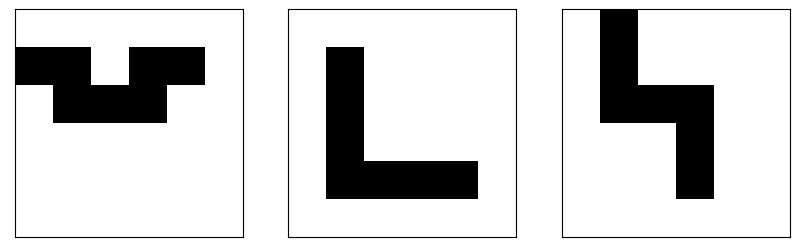

In [69]:
test = np.array(
    [[[0,0,0,0,0,0],
      [1,1,0,1,1,0],
      [0,1,1,1,0,0],
      [0,0,0,0,0,0],
      [0,0,0,0,0,0],
      [0,0,0,0,0,0]],
     [[0,0,0,0,0,0],
      [0,1,0,0,0,0],
      [0,1,0,0,0,0],
      [0,1,0,0,0,0],
      [0,1,1,1,1,0],
      [0,0,0,0,0,0]],
     [[0,1,0,0,0,0],
      [0,1,0,0,0,0],
      [0,1,1,1,0,0],
      [0,0,0,1,0,0],
      [0,0,0,1,0,0],
      [0,0,0,0,0,0]]]
)

fig, axs = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(10,6))
for i in range(3):
    axs[i].imshow(test[i], cmap='Greys')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    print(f'Classification for image {i+1}: {model_classify(M, test[i])}')

The function `check_model()` tests a given model on all 3455 inputs containing digits. Our exact model correctly classifies every input.

In [70]:
print(f'Correct classifications: {check_model(M=M)}/{x_all.shape[0]} ({100*check_model(M=M)/x_all.shape[0]}%)')


Correct classifications: 3455/3455 (100.0%)


## Example 7.2

The example below trains an approximate model. The training parameters `r`, `epochs`, and `batch_size` can be modified. There is an early stopping criteria that can be tuned with `patience`, or turned off by setting `patience = None`. The learning rate and batch size have been adjusted to try to reduce the presence of periods where the loss does not consistently decrease and it seems to be necessary to further adjust the patience of the stopping criteria to allow for these.

We also print the number of correct classifications the model makes to ensure we have satisfactory performance.

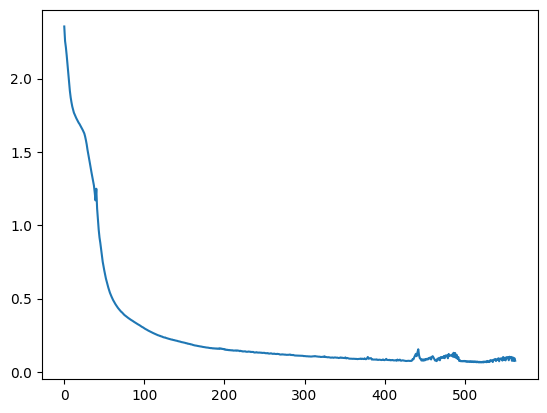

Correct classifications: 3361/3455 (97.28%)


In [71]:
r = 0.003
epochs = 1000
batch_size = 128
patience = 40

M = make_approx_model(p=3, q=3, r=r)
hist = train_approx_model(M=M, epochs=epochs, batch_size=batch_size, patience=patience)
plt.plot(hist.history['loss'])
plt.show()
print(f'Correct classifications: {check_model(M=M)}/{x_all.shape[0]} ({np.round(100*check_model(M=M)/x_all.shape[0], 2)}%)')

We can visualize the kernels of the first layer using the code below. In most cases the kernels do not seem to show any particular resemblance to the kernels we created to recognize specific pixel types, and there seem to be lots of possible local minima at which the model can arrive.

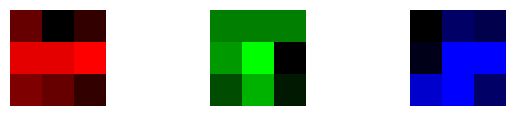

In [72]:
show_kernels(M=M)

## Example 7.3

This example aims to train models similar to the previous one, but initializing the weights of the first layer using the kernels from the first layer of the exact model. The `start_kernels` list should contain 3 digits from 0 to 9 representing the pixel types that the kernels are initalized to.

The output shows the number of correct classifications and the loss against time during training. We see that with several combinations of starting kernels, we can achieve much more stable behaviour in training and achieve >98% accuracy consistently.

Correct classifications: 3454/3455 (99.97%)


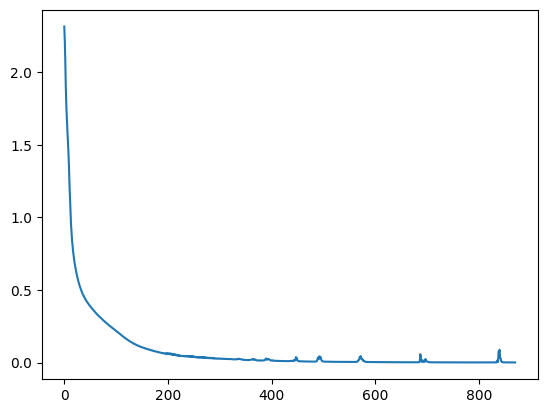

In [73]:
start_kernels = [0,6,9]

M, hist = test_starting_kernel(sk=start_kernels, r=0.003, epochs=1000, batch_size=128, patience=40)
print(f'Correct classifications: {check_model(M=M)}/{x_all.shape[0]} ({np.round(100*check_model(M=M)/x_all.shape[0], 2)}%)')
plt.plot(hist.history['loss'])
plt.show()

The code below shows the starting kernels for the first layer versus their final state. The shape of the starting kernels can consistently be seen within the final kernels, indicating the starting kernels provide some sort of guidance towards a specific group of local minima during training.

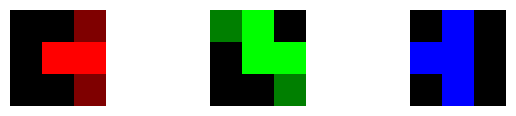

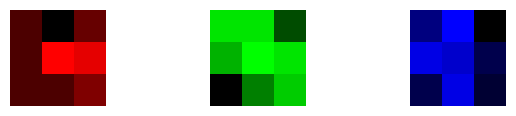

In [74]:
M_exact = make_exact_model()
w_exact = M_exact.layers[2].get_weights()[0][:,:,:,start_kernels]
b_exact = M_exact.layers[2].get_weights()[1][start_kernels]
M_exact = tf.keras.models.clone_model(M)
M_exact.layers[2].set_weights([w_exact,b_exact])
show_kernels(M=M_exact)
show_kernels(M=M)

## Example 7.4

This example shows the experiment to try to find a somewhat optimal combination of starting kernels. The function `test_all()` tests models with the weights in the first layer initialized to three copies of the kernel for each pixel type in turn. Five models are trained for each type and the mean number of correct classifications are shown. This test takes a long time to run without GPU acceleration.

In [75]:
scores, models = test_all()
[print(f'Pixel type {i}: {scores[i]}') for i in range(10)]
None

Pixel type 0: 3439.6
Pixel type 1: 3381.2
Pixel type 2: 3431.8
Pixel type 3: 3386.4
Pixel type 4: 3450.4
Pixel type 5: 3438.6
Pixel type 6: 3410.6
Pixel type 7: 3433.6
Pixel type 8: 3421.0
Pixel type 9: 3402.0


From this list we can examine the trained kernels of the five models against the starting kernels to see if any patterns emerge.

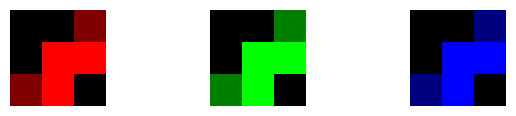

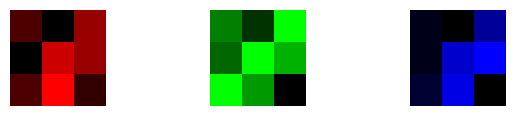

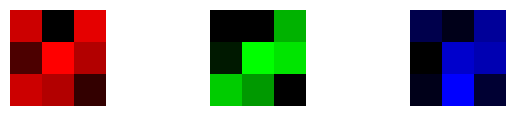

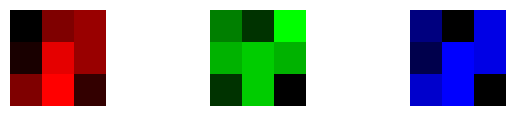

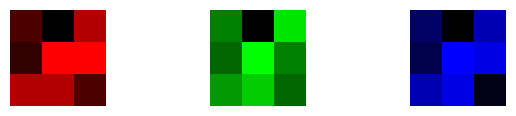

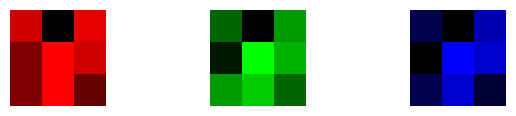

In [76]:
sk = np.argmax(np.array(scores))
start_kernels = [sk]*3
best_models = models[sk]
M_exact = make_exact_model()
w_exact = M_exact.layers[2].get_weights()[0][:,:,:,start_kernels]
b_exact = M_exact.layers[2].get_weights()[1][start_kernels]
M_exact = tf.keras.models.clone_model(best_models[0])
M_exact.layers[2].set_weights([w_exact,b_exact])
show_kernels(M_exact)
[show_kernels(M=m) for m in best_models]
None

## Figure code

The following code produce the figures contained in this chapter.

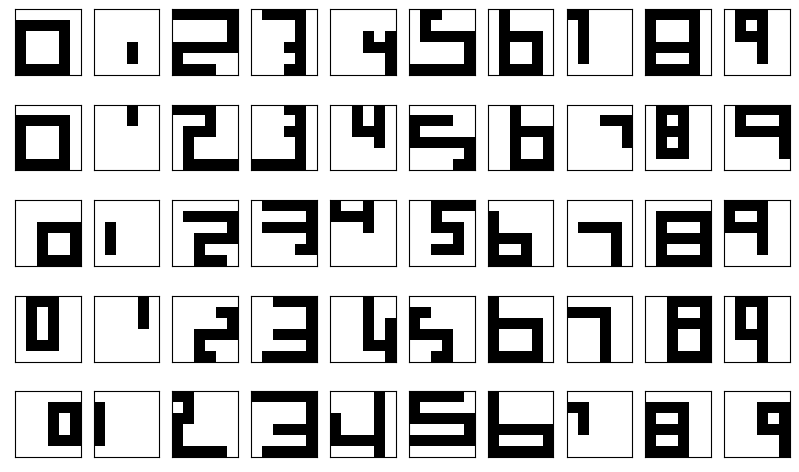

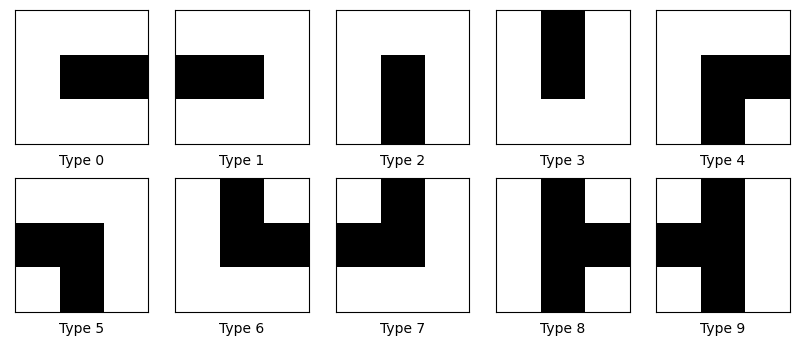

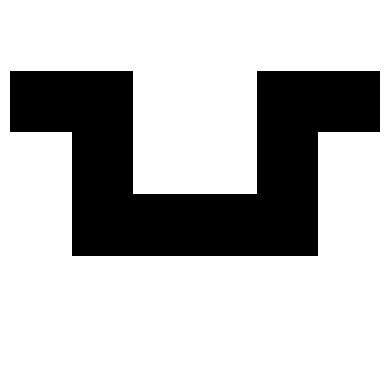

In [77]:
tf.random.set_seed(210138711)

# Figure 1
fig, axs = plt.subplots(5, 10, sharex='col', sharey='row', figsize=(10,6))

for i in range(5):
    for j in range(10):
        axs[i,j].imshow(random_image(j), cmap='Greys')
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])


# Figure 2
fig, axs = plt.subplots(2, 5, sharex='col', sharey='row', figsize=(10,4))

pixels = [
    [[0, 0, 0], [0, 1, 1], [0, 0, 0]],
    [[0, 0, 0], [1, 1, 0], [0, 0, 0]],
    [[0, 0, 0], [0, 1, 0], [0, 1, 0]],
    [[0, 1, 0], [0, 1, 0], [0, 0, 0]],
    [[0, 0, 0], [0, 1, 1], [0, 1, 0]],
    [[0, 0, 0], [1, 1, 0], [0, 1, 0]],
    [[0, 1, 0], [0, 1, 1], [0, 0, 0]],
    [[0, 1, 0], [1, 1, 0], [0, 0, 0]],
    [[0, 1, 0], [0, 1, 1], [0, 1, 0]],
    [[0, 1, 0], [1, 1, 0], [0, 1, 0]]
]

pixels = np.array(pixels)

for i in range(2):
    for j in range(5):
        axs[i,j].imshow(pixels[5*i+j], cmap='Greys')
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].set(xlabel=f"Type {5*i+j}")


# Figure 3
fig = plt.figure()
non_digit = np.array(
    [[0,0,0,0,0,0],
     [1,1,0,0,1,1],
     [0,1,0,0,1,0],
     [0,1,1,1,1,0],
     [0,0,0,0,0,0],
    [ 0,0,0,0,0,0]]
)

show_digit(non_digit)

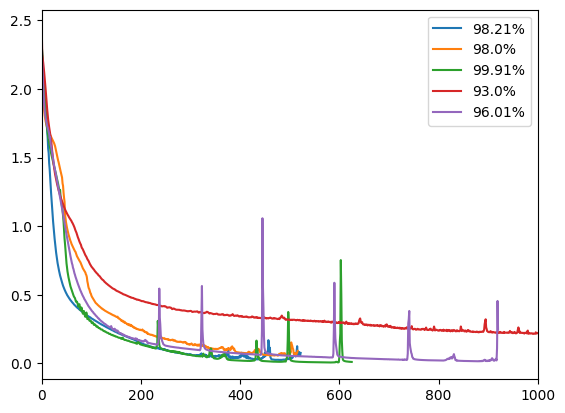

In [78]:
tf.random.set_seed(210138711)

# Figure 4
r = 0.003
epochs = 1000
batch_size = 128
patience = 40

cols = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
models = []
hists = []
for i in range(5):
    models.append(make_approx_model(p=3, q=3, r=r))
    hists.append(train_approx_model(M=models[i], epochs=epochs, batch_size=batch_size, patience=patience))
    plt.gca().set_xlim([0,1000])
    plt.plot(hists[i].history['loss'], color=cols[i], label=f'{np.round(100*check_model(M=models[i])/x_all.shape[0], 2)}%')

plt.gca().legend(loc='upper right', ncol=1)
plt.show()

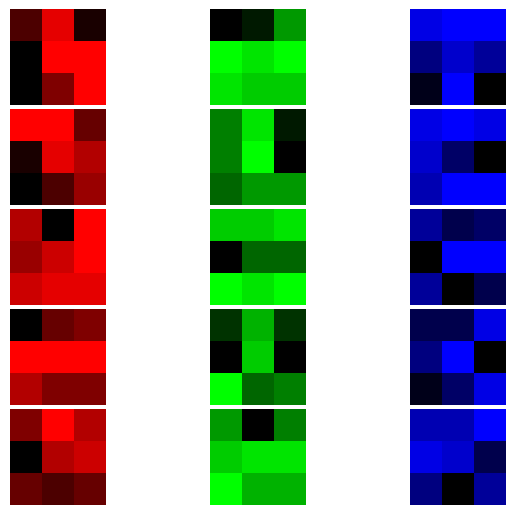

In [79]:
# Figure 5
fig = plt.figure(figsize=(5, 1))

for i in range(5):
    w = models[i].layers[2].get_weights()[0].reshape(3, 3, 3).transpose(2, 0, 1)
    for j in range(3):
        cm0 = np.zeros([11, 4])
        for k in range(11):
            cm0[k, j] = k / 10
            cm0[k, 3] = 1
        cm = matplotlib.colors.ListedColormap(cm0)
        x = (2*j - 0.02) / 5
        ax = fig.add_axes([x, 0.02 + i, 0.96 / 5, 0.96])
        ax.set_axis_off()
        ax.imshow(w[j], cmap=cm)

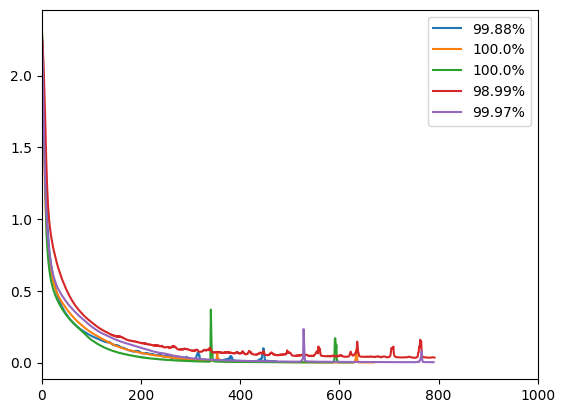

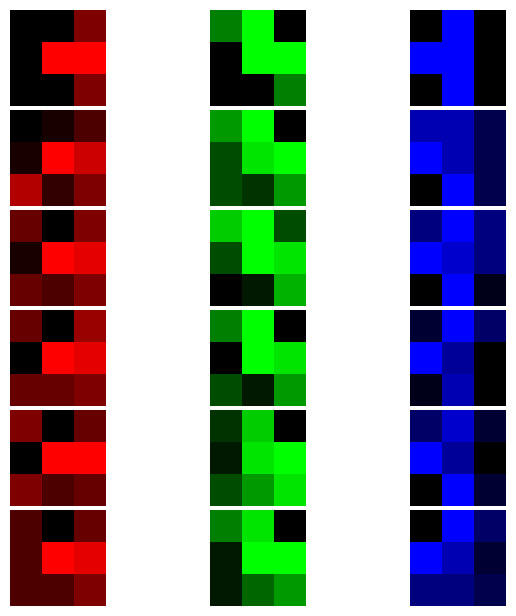

In [80]:
# Figure 6
start_kernels = [0,6,9]

cols = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
models = []
hists = []
for i in range(5):
    M, hist = test_starting_kernel(sk=start_kernels, r=0.003, epochs=1000, batch_size=128, patience=40)
    models.append(M)
    hists.append(hist)
    plt.gca().set_xlim([0,1000])
    plt.plot(hist.history['loss'], color=cols[i], label=f'{np.round(100*check_model(M=models[i])/x_all.shape[0], 2)}%')
plt.gca().legend(loc='upper right', ncol=1)
plt.show()

# Figure 7
M_exact = make_exact_model()
w_exact = M_exact.layers[2].get_weights()[0][:,:,:,start_kernels]
b_exact = M_exact.layers[2].get_weights()[1][start_kernels]
M_exact = tf.keras.models.clone_model(models[0])
M_exact.layers[2].set_weights([w_exact,b_exact])

models.append(M_exact)
fig = plt.figure(figsize=(5, 1))

for i in range(6):
    w = models[i].layers[2].get_weights()[0].reshape(3, 3, 3).transpose(2, 0, 1)
    for j in range(3):
        cm0 = np.zeros([11, 4])
        for k in range(11):
            cm0[k, j] = k / 10
            cm0[k, 3] = 1
        cm = matplotlib.colors.ListedColormap(cm0)
        x = (2*j - 0.02) / 5
        ax = fig.add_axes([x, 0.02 + i, 0.96 / 5, 0.96])
        ax.set_axis_off()
        ax.imshow(w[j], cmap=cm)

[3378.8, 3385.8, 3449.8, 3444.4, 3452.4, 3410.8, 3445.4, 3434.2, 3437.0, 3454.6]


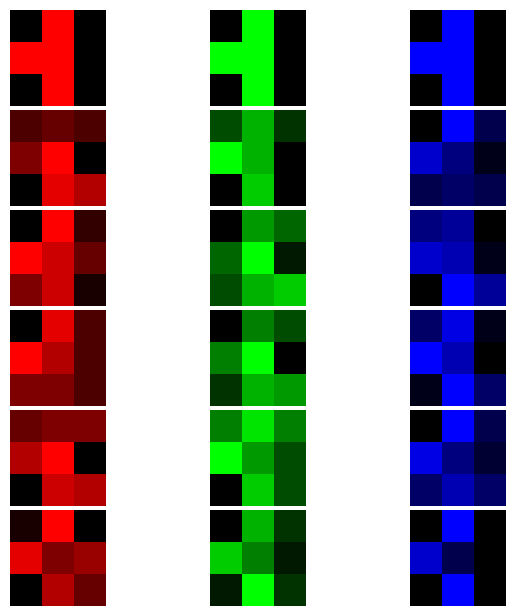

In [81]:
#Figure 8
scores, models = test_all()
sk = np.argmax(np.array(scores))
start_kernels = [sk]*3
best_models = models[sk]

M_exact = make_exact_model()
w_exact = M_exact.layers[2].get_weights()[0][:,:,:,start_kernels]
b_exact = M_exact.layers[2].get_weights()[1][start_kernels]
M_exact = tf.keras.models.clone_model(best_models[0])
M_exact.layers[2].set_weights([w_exact,b_exact])

best_models.append(M_exact)
fig = plt.figure(figsize=(5, 1))

for i in range(6):
    w = best_models[i].layers[2].get_weights()[0].reshape(3, 3, 3).transpose(2, 0, 1)
    for j in range(3):
        cm0 = np.zeros([11, 4])
        for k in range(11):
            cm0[k, j] = k / 10
            cm0[k, 3] = 1
        cm = matplotlib.colors.ListedColormap(cm0)
        x = (2*j - 0.02) / 5
        ax = fig.add_axes([x, 0.02 + i, 0.96 / 5, 0.96])
        ax.set_axis_off()
        ax.imshow(w[j], cmap=cm)

In [82]:
[print(np.round(100*s/3455, 2)) for s in scores]
None

97.79
98.0
99.85
99.69
99.92
98.72
99.72
99.4
99.48
99.99


[None, None, None, None, None, None, None, None, None, None]